## Overview

In this file I will be creating a low risk portfolio from a set of seven stocks being ABBV(AbbVie Inc), XOM(ExxonMobilCorp), HD(Home Depot), COST(Costco), AAPL(Apple), JPM(JP Morgan Chase), and VZ(Verizon). In order to achieve my goal of having a low risk profile while not hurting the main goal of investment which is making profit, I applied some principles in choosing these stocks;

1) I chose seven stocks and while just increasing the number of stocks in a portfolio doesn't lower the risk associated to it, it certaily provides the grounds for it

2) I chose these stcoks from different sectors. If all are chosen from the same sector, they tend to move together, exposing your portfolio to sector-specific downturns.

3) I chose stcoks that answer a necessary need of people like Costco and Verizon. This way I'm safegaurding myself from huge downturns as people always need the products of these stocks.

4) I also increased my time horizon to 5 years to metigate the risk 

5) Lastly, considering all the above points I reached at more candidates and chose the ones with higher dividend and annual return rates

In [526]:
#import packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.optimize import minimize
import datetime as dt
import warnings
sns.set_style('darkgrid')

warnings.filterwarnings("ignore")
import yfinance as yf

#Below, we'll create a low risk portfolio.
tickers = ['ABBV', 'XOM', 'HD', 'COST', 'AAPL','JPM','VZ']
start_date = dt.datetime.today()-dt.timedelta(days = 5*365)
end_date = dt.datetime.today()
stock = yf.download(tickers, start = start_date, end =end_date)



[*********************100%***********************]  7 of 7 completed


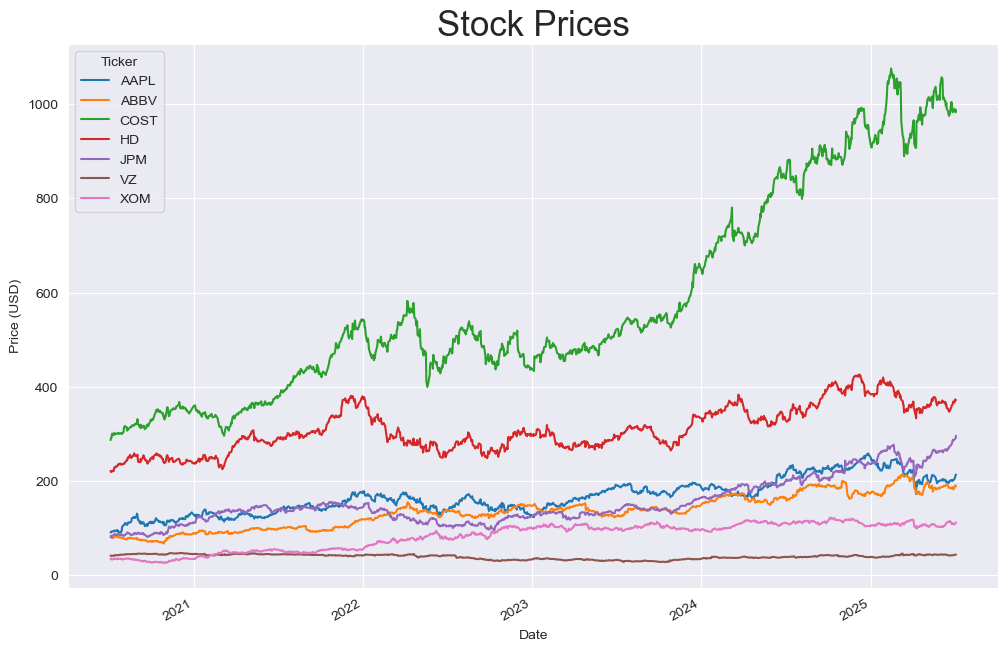

Ticker,AAPL,ABBV,COST,HD,JPM,VZ,XOM
Date,,,,,,,
2020-07-06,90.852013,80.672752,286.836609,221.245392,83.070801,41.405876,35.370308
2020-07-07,90.570107,80.949783,291.201477,219.294922,80.727333,41.255966,34.453972
2020-07-08,92.679482,80.892746,291.284332,220.908463,81.584290,41.510826,34.374298
2020-07-09,93.078041,79.800919,299.774628,219.835754,79.817932,40.885483,32.955975
2020-07-10,93.240860,78.896492,300.410156,221.741837,84.181328,41.302376,33.983860


In [527]:
stock['Close'].plot(figsize = (12,8))
plt.title(f'Stock Prices', size = 25)
plt.ylabel('Price (USD)')
plt.show()
close = stock['Close']
close.head()

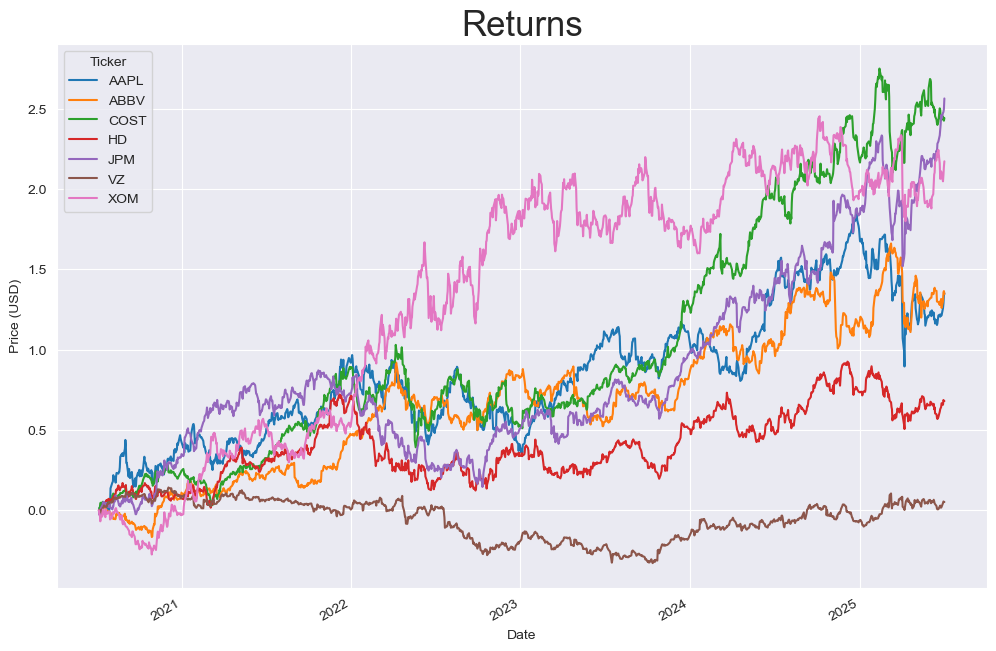

Typical method of finding volatility is to find the (log) daily returns take standard deviation and then multiply by sqrt(252) to give the yearly volatility.


In [528]:
close = stock['Close']
normalized_returns = close/close.iloc[0]-1 #Moves stock prices to a start of 0


# Step 2: Create MultiIndex columns for new data
normalized_returns.columns = pd.MultiIndex.from_product([['Cumulative Return'], normalized_returns.columns])

# Step 3: Concatenate to the original DataFrame
stock = pd.concat([stock, normalized_returns], axis =1 )
#Plot Cumlative Returns together
stock['Cumulative Return'].plot(figsize = (12,8))
plt.title(f'Returns', size = 25)
plt.ylabel('Price (USD)')
plt.show()
print('Typical method of finding volatility is to find the (log) daily returns take standard deviation and then multiply by sqrt(252) to give the yearly volatility.')

In [529]:
tickers = ['ABBV', 'XOM', 'HD', 'COST', 'AAPL','JPM','VZ']
start_date = dt.datetime.today()-dt.timedelta(days = 5*365)
end_date = dt.datetime.today()

stock = yf.download(tickers, start = start_date, end = end_date)

[*********************100%***********************]  7 of 7 completed


In [530]:
#Create a dataframe of daily returns
#It is quite common to take the logs of daily returns to lessen computational complexity in standard deviation
daily_returns = np.log(stock['Close']/stock['Close'].shift(1))
daily_returns = daily_returns.dropna()

#Create a dictionary of standard deviations of daily return
#Normalize the standard deviation for yearly by multiplying by sqrt(#trading days in year ~ 252)
annualized_volatility = {ticker: np.std(daily_returns[ticker])*np.sqrt(252) for ticker in tickers}
annualized_volatility

{'ABBV': 0.2275552567232904,
 'XOM': 0.2936072760017686,
 'HD': 0.23598614661405531,
 'COST': 0.22739263027637704,
 'AAPL': 0.2974373689250643,
 'JPM': 0.256159331244929,
 'VZ': 0.20221896663096856}

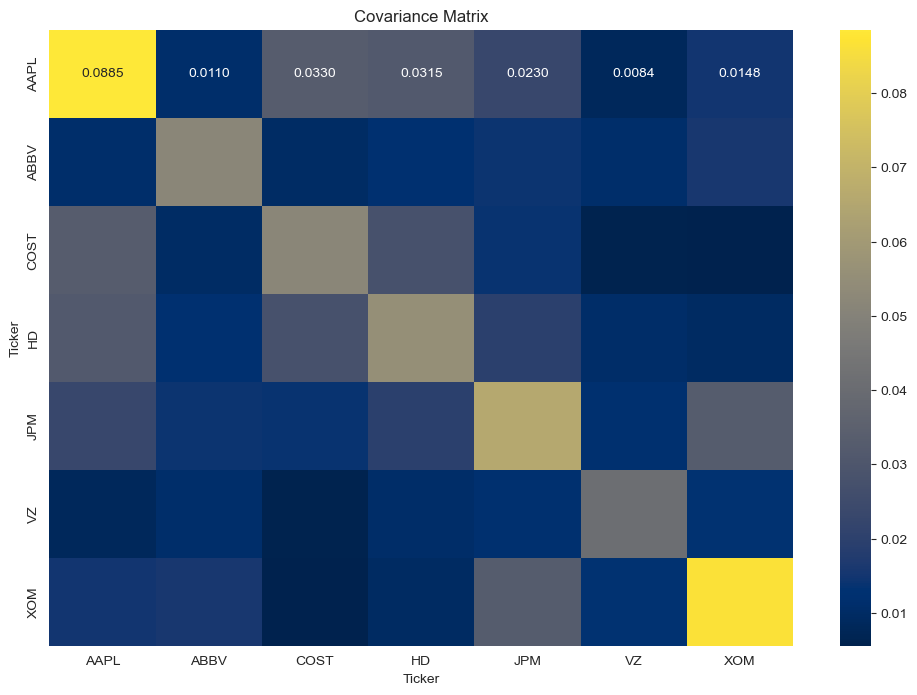

In [531]:
covariance_matrix = 252*((daily_returns).cov())
covariance_matrix
# Create a heatmap to visualize the covariance matrix
plt.figure(figsize = (12,8))
sns.heatmap(covariance_matrix, annot=True, cmap='cividis', fmt ='.4f')
plt.title('Covariance Matrix')
plt.show()

So far I have calculated several basic statistical values which show low covariance in the past 5 years which is good for our optimization. In the next steps we'll perform the optimization and calculated several other features of our final portfolio

Optimal Asset Weights to minimize volatility:
ABBV: Weight = 0.0300
XOM: Weight = 0.1960
HD: Weight = 0.2085
COST: Weight = 0.0859
AAPL: Weight = 0.0744
JPM: Weight = 0.3183
VZ: Weight = 0.0870


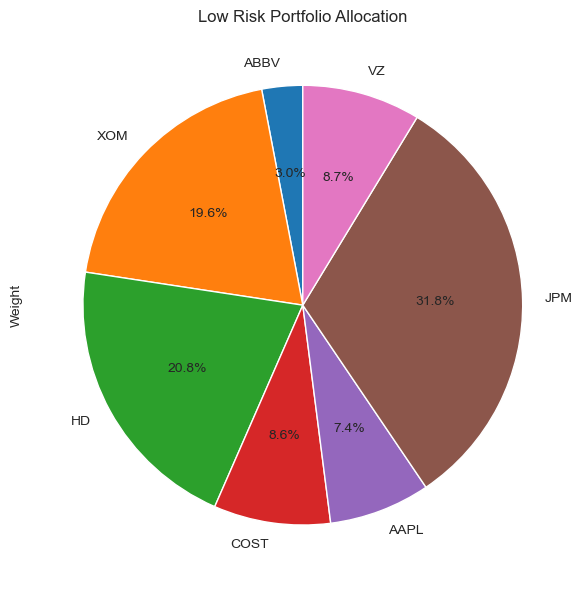

In [532]:
#Find a set of weights, equivalently portfolio investment percentages in stock_symbols, 
#which minimizes a historical portfolio's volatility subject to the following investment constraints
#1) Must invest at least 3% of capital into each index
#2) Cannot invest more than 70% of capital into a single index

#Create dictionary average/expected daily return for indexes in stock_symbols normalized for yearly return
#expected_returns = {stock: 252*np.mean(returns[stock]) for stock in stock_symbols}


# Number of assets
n_assets = len(tickers)

# Define an initial guess for asset weights (e.g., equal weights)
initial_weights = np.array([1/n_assets] * n_assets)

# Define weight constraints
#Sum of weights equals 1 
#Allocate at least 3% of capital into each index in stock_symbols
#Do not allocate more than 70% of capital into each index in stock_symbol
constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights)-1},
               {'type': 'ineq', 'fun': lambda weights: min(weights)-.03},
              {'type': 'ineq', 'fun': lambda weights: .7-max(weights)})

# Define the objective function to minimize portfolio variance
def portfolio_volatility(weights):
    portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(covariance_matrix, weights)))
    return portfolio_std_dev

# Run the optimization to find the optimal weights
result = minimize(portfolio_volatility, initial_weights, constraints=constraints)

# Optimal asset weights
optimal_weights = result.x

# Print the optimal weights and expected returns
print('Optimal Asset Weights to minimize volatility:')
for ticker, weight in zip(tickers, optimal_weights):
    print(f"{ticker}: Weight = {weight:.4f}")

low_weight_table = pd.Series(optimal_weights, index=tickers, name='Weight')
fig, ax = plt.subplots(figsize=(14, 6))
low_weight_table.plot.pie(ax=ax, autopct='%1.1f%%', startangle=90)
ax.set_title("Low Risk Portfolio Allocation")
plt.tight_layout()
plt.show()

In [533]:
print(f' The optimal volatility subject to the constraints is {result.fun}')

 The optimal volatility subject to the constraints is 0.1398749594774329


In [534]:
# Dictionary to hold dividend series
dividends_dict = {}

for ticker in tickers:
    
    t = yf.Ticker(ticker)
    # Get dividend history and filter by your date range
    dividends = t.dividends
    dividends.index = dividends.index.tz_localize(None)
    dividends = dividends[(dividends.index >= start_date) & (dividends.index <= end_date)]
    dividends_dict[ticker] = dividends

# Convert to DataFrame: one column per ticker
dividends_df = pd.DataFrame(dividends_dict)

# Optional: fill NaNs with 0 (where dividends weren’t paid)
dividends_df = dividends_df.fillna(0)

# View a sample
print(dividends_df.head())
print(dividends_df.tail())

            ABBV   XOM   HD  COST   AAPL  JPM     VZ
Date                                                
2020-07-09  0.00  0.00  0.0   0.0  0.000  0.0  0.615
2020-07-14  1.18  0.00  0.0   0.0  0.000  0.0  0.000
2020-07-30  0.00  0.00  0.0   0.7  0.000  0.0  0.000
2020-08-07  0.00  0.00  0.0   0.0  0.205  0.0  0.000
2020-08-12  0.00  0.87  0.0   0.0  0.000  0.0  0.000
            ABBV   XOM   HD  COST  AAPL  JPM   VZ
Date                                             
2025-05-02   0.0  0.00  0.0   1.3  0.00  0.0  0.0
2025-05-12   0.0  0.00  0.0   0.0  0.26  0.0  0.0
2025-05-15   0.0  0.99  0.0   0.0  0.00  0.0  0.0
2025-06-05   0.0  0.00  2.3   0.0  0.00  0.0  0.0
2025-07-03   0.0  0.00  0.0   0.0  0.00  1.4  0.0


ABBV   | 5-Yr Avg Yield: 3.02% | Weighted: 0.09%
XOM    | 5-Yr Avg Yield: 3.26% | Weighted: 0.64%
HD     | 5-Yr Avg Yield: 2.11% | Weighted: 0.44%
COST   | 5-Yr Avg Yield: 0.89% | Weighted: 0.08%
AAPL   | 5-Yr Avg Yield: 0.43% | Weighted: 0.03%
JPM    | 5-Yr Avg Yield: 1.44% | Weighted: 0.46%
VZ     | 5-Yr Avg Yield: 5.97% | Weighted: 0.52%

 5-Year Avg Annual Portfolio Dividend Yield: 2.25%


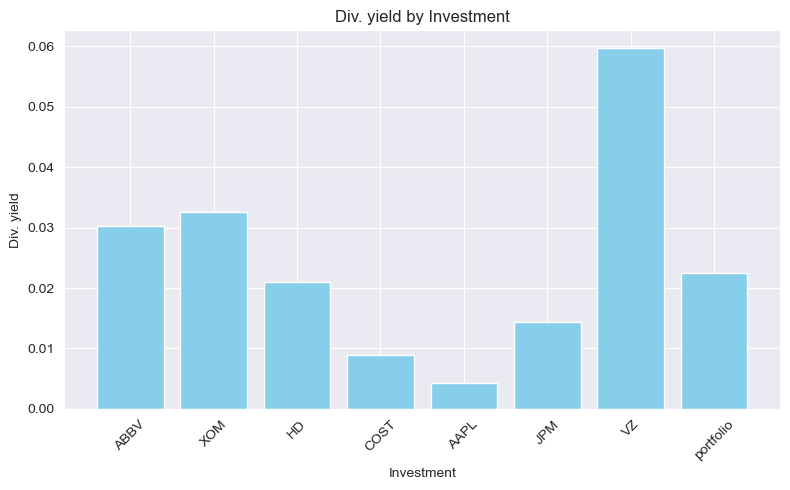

In [535]:
dividend_yields = []

for ticker in tickers:
    t = yf.Ticker(ticker)
    
    # Get dividend history and remove timezone
    div = t.dividends
    div.index = div.index.tz_localize(None)
    
    # Filter last 5 years
    div_5y = div[(div.index >= start_date) & (div.index <= end_date)]
    total_div_5y = div_5y.sum()
    
    # Average annual dividends over 5 years
    avg_annual_div = total_div_5y / 5
    
    # Get most recent price
    price = t.history(period='1d')['Close'].iloc[-1]
    
    # Compute 5-year average annual dividend yield
    yield_pct = avg_annual_div / price if price > 0 else 0
    dividend_yields.append(yield_pct)

# Compute weighted portfolio dividend yield
portfolio_div_yield = sum(w * y for w, y in zip(optimal_weights, dividend_yields))

# Show results
dividend_dict = {}
for ticker, w, y in zip(tickers, optimal_weights, dividend_yields):
    
    dividend_dict[ticker] = y
    print(f"{ticker:<6} | 5-Yr Avg Yield: {y:.2%} | Weighted: {(w * y):.2%}")
    
print("\n 5-Year Avg Annual Portfolio Dividend Yield:", f"{portfolio_div_yield:.2%}")

dividend_dict['portfolio'] = portfolio_div_yield
companies = list(dividend_dict.keys())
yields = list(dividend_dict.values())

plt.figure(figsize=(8, 5))
plt.bar(companies, yields, color='skyblue')
plt.xlabel("Investment")
plt.ylabel("Div. yield")
plt.title("Div. yield by Investment")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [536]:
stock = yf.download(tickers, start = start_date, end =end_date)
stock['Close']
annual_returns = {}

n_years = 5  # since your data is from the past 5 years

for ticker in tickers:
    series = stock['Close'][ticker]
    price_start = series.iloc[0]
    price_end = series.iloc[-1]

    # Calculate annualized return (CAGR)
    annual_return = (price_end / price_start) ** (1 / n_years) - 1
    annual_returns[ticker] = annual_return

# Print results
for ticker, r in annual_returns.items():
    print(f"{ticker}: {r:.2%} annualized return over {n_years} years")

[*********************100%***********************]  7 of 7 completed

ABBV: 18.60% annualized return over 5 years
XOM: 25.97% annualized return over 5 years
HD: 10.93% annualized return over 5 years
COST: 28.04% annualized return over 5 years
AAPL: 18.64% annualized return over 5 years
JPM: 28.93% annualized return over 5 years
VZ: 1.01% annualized return over 5 years


0.5579252924111593%
5.089373959657665%
2.278900428659967%
2.407571956172712%
1.386936859154639%
9.209912871557535%
0.08830113952275682%
Estimated Portfolio Annualized Return: 21.018922507136434%


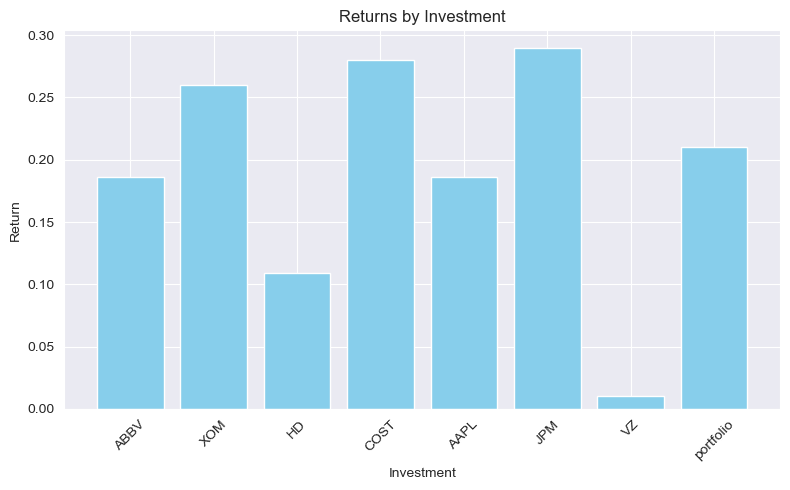

In [537]:
portfolio_return = 0

for ticker, w in zip(annual_returns.items(),optimal_weights):
    
    
    print(str(w * ticker[1]*100) + '%')
    portfolio_return = portfolio_return + w * ticker[1]
    

print(f"Estimated Portfolio Annualized Return: {str(portfolio_return * 100) + '%'}")
annual_returns['portfolio'] = portfolio_return

investment = list(annual_returns.keys())
values = list(annual_returns.values())

# Plot bar chart
plt.figure(figsize=(8, 5))
plt.bar(investment, values, color='skyblue')
plt.xlabel("Investment")
plt.ylabel("Return")
plt.title("Returns by Investment")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Conclusion

At last, notice that after obtaining the optimal weights we got a portfolio that would have almost 14% volitility which compared to volitility of each stock which is above 20% and considered high risk is great. It's worth noting that S&P 500 has volitility around 15% in long term. Also, we hit 2.25% dividend yield with this portfolio which is a very good rate considering the market and finally this portfolio would have had a 21% annualized return in the past 5 years which is amazing.
This shows that increasing the number stocks while diversifying over sectors and successful stock allows us to grow portfolios dividend and annual return while keeping the volitility low.

## Future improvements: 
1) The code can be cleaner.
2) I haven't incorporated any ML models that can heavily help the analysis. So, I'd like to add such analysis in the future
3) It would also be nice to add some type of auto-hedging which further reduce the risk associated to our investment